# **UofT DSI Sampling**
**Assessment: Sampling and Reproducibility in Python**

Submitted by Suzanne M Chalambalacis
11-Mar-2024

Read the blog post Contact tracing can give a biased sample of COVID-19 cases by Andrew Whitby to understand the context and motivation behind the simulation model we will be examining.

https://andrewwhitby.com/2020/11/24/contact-tracing-biased/


Examine the code in whitby_covid_tracing.py. Identify all stages at which sampling is occurring in the model. Describe in words the sampling procedure, referencing the functions used, sample size, sampling frame, any underlying distributions involved, and how these relate to the procedure outlined in the blog post.

**Answer:**

**The code in `whitby_covid_tracing.py` simulates the infection and tracing process for a series of events, particularly weddings and brunches.**

**The code selects a random subset of people to be infected based on the `ATTACK_RATE`(set to 0.10) to determine the proportion of the population that gets infected.**

```
  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True
```

**The code randomly decides which infected people get traced in the primary contact tracing step.**
```
# Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS
```
**The code then performs a secondary contact tracing based on event attendance.**
```
  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True
```
**Overall, the code simulates the spread of infection in events, considers primary and secondary contact tracing, and calculates proportions of infections and traces attributed to specific event types. The sampling procedures involve random selection of infected individuals, random primary contact tracing, and event-based secondary contact tracing. The code aims to demonstrate how the contact tracing process can lead to biased perceptions of infection sources, consistent with the concepts discussed in the blog post.**

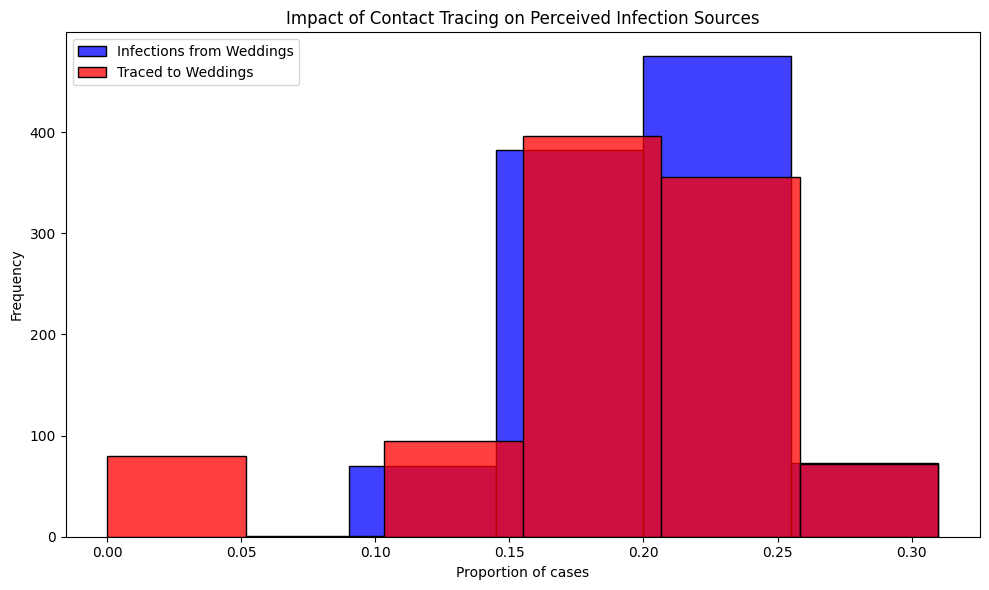

In [ ]:
# whitby_covid_tracing.py

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.

  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.

  Parameters:
  - m: Dummy parameter for iteration purposes.

  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces

# Set the random seed for reproducibility
np.random.seed(10)

# Run the simulation 1000 times
results = [simulate_event(m) for m in range(1000)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()


Run the Python script file called whitby_covid_tracing.py as is and compare the results to the graphs in the original blog post. Does this code appear to reproduce the graphs from the original blog post?

**Answer:**

**Overall, the graphs from the original blog post and by running the py code differ. In the graph for the original blog post, the True Proportion spans between 10% to 30% with a peak at 20%, while the Observed Proportion spans from 5%, then gradually peaks at 50% and decreases around 80%. In the graph outputed from the `whitby_covid_tracing.py`, both the Infected and Traced frequency overlap and span between 10% to 30% with a peak at 20%.**


Modify the number of repetitions in the simulation to 1000 (from the original 50000). Run the script multiple times and observe the outputted graphs. Comment on the reproducibility of the results.

**Answer:**
**The `whitby_covid_tracing.py` code already has the number of repetions set to 1000.**
```
results = [simulate_event(m) for m in range(1000)]
```
**The sample size is small at 1,000 e.g. `['wedding'] * 200 + ['brunch'] * 800` so increasing the sample size would create a more realistic scenario. The script also lacks a fixed seed for the random number generator so if it is run multiple times with 1,000 repetitions it will output different histograms reflecting the variability in the simulated outcomes due to the random nature of the infection and tracing processes.**


Alter the code so that it is reproducible. Describe the changes you made to the code and how they affected the reproducibility of the script file. The output does not need to match Whitby’s original blogpost/graphs, it just needs to produce the same output when run multiple times.

**Answer:**

**To make the code more reproducbile, I made the following changes:**

**Qaudrupled the number of events to 4,000 (800 weddings and 3,200 brunches) to better reflect a larger sample size.**
```
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 800 + ['brunch'] * 3200
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })
```

**Fixed the seed value to `np.random.seed(100)` before running the simulation loop so that the script is set up to produce the same set of random numbers each time it is run.**

```
# Fix the random seed for reproducibility
np.random.seed(100)
```

**Increased the number of repetions from 1,000 to 10,000 to provide a more stable estimate of the distribution of infections and traces.**
```
# Run the simulation 10000 times
results = [simulate_event(m) for m in range(10000)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])
```

**The adjusted random seed and increased iterations and  number of events creates a more realistic scenario and should produce similar histograms, capturing the underlying patterns in the simulated data, when running the script multiple times.**

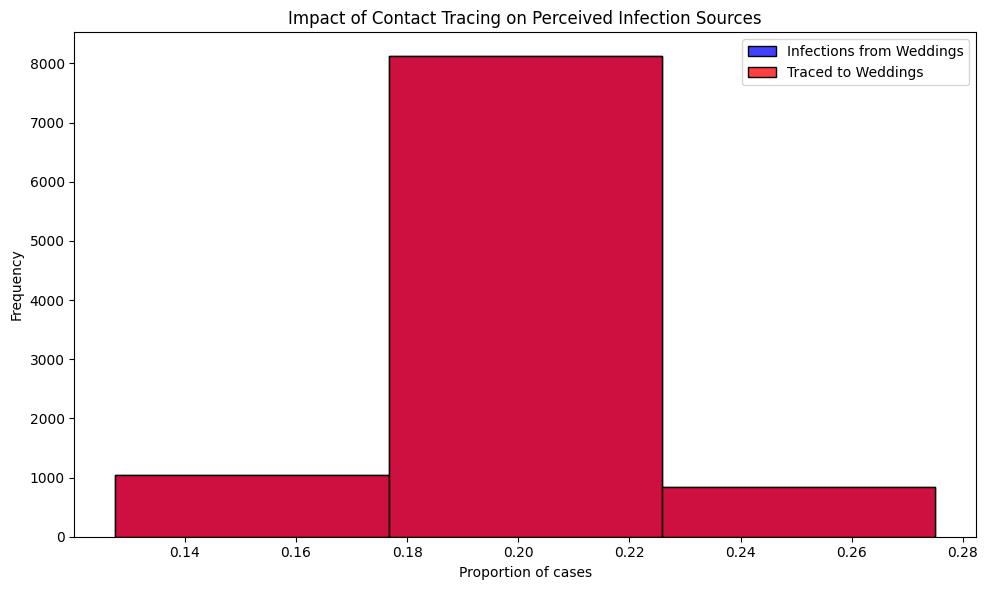

In [ ]:
# whitby_covid_tracing.py - modified version

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.

  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.

  Parameters:
  - m: Dummy parameter for iteration purposes.

  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 800 + ['brunch'] * 3200
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces

# Fix the random seed for reproducibility
np.random.seed(100)

# Run the simulation 10000 times
results = [simulate_event(m) for m in range(10000)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()
